In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# Set plotting style
sns.set_style("white")

%matplotlib inline

# Probability Functions

These functions determine the probability of various events, and use them to compute the expected number of values given a certain number of rolls.

In [2]:
def fate_probability(value):
    """Returns the probability of rolling a value on 4dF.

    Args:
        value (int): The value rolled on 4dF.

    Returns:
        float: The probability of rolling the value, that is P(4dF=value).

    Raises:
        TypeError: If -4 <= value <= 4 and value is not an integer.

    """
    # Outside bounds
    if not -4 <= value <= 4:
        return 0

    # The probability of rolling a sum of 0, 1, 2, 3, 4 (negatives are same probability)
    probability = [19/81, 16/81, 10/81, 4/81, 1/81]

    return probability[abs(value)]

In [3]:
def configuration_probability(value, n_times, m_tries):
    """ Give the probability of rolling a value exactly N times on 4dF, given M
    rolls.

    The formula for the probability is:

    (M choose N) * P(Value)^N * P(Not Value)^{M-N}

    Where (M choose N) is the binomial coefficient, P(Value)^N is the
    probability of rolling the value exactly N times, and P(Not Value)^{M-N} is
    the probability of rolling any other result M-N times.

    Args:
        value (int): The value rolled on 4dF.
        n_times (int): The number of times the value should appear.
        m_tries (int): The total number of 4dF rolls.

    Returns:
        float: The probability of the desired combination.
    """
    # Binomial coefficient
    coeff = math.factorial(m_tries) // (math.factorial(n_times) * math.factorial(m_tries - n_times))
    p = fate_probability(value)

    total_probability = coeff * (p**n_times) * ((1-p)**(m_tries-n_times))

    return total_probability

In [4]:
def get_interval(m_tries, start=0.025, end=0.975):
    """Find the lower and upper bounds on the number of times 4dF should roll a
    certain value given m total rolls.

    The lower bound is defined as n such that CP(n) < start < CP(n+1).
    The upper bound is defined as n such that CP(n) < end < CP(n+1)

    CP(n) is the cumulative probability, such that:

        CP(n) = Sum of P(i) for 0 <= i <= n

    Args:
        m_tries (int): The total number of 4dF rolls.

    Returns:
        array of tuples: An array of tuples for the lower and upper bounds
            expected for rolling values -4, -3, -2, -1, 0, 1, 2, 3, 4 on 4dF
            rolled m times. The array has the following form:

            [
                (lower, upper), # Bounds for number of -4s expected
                (lower, upper), # Bounds for number of -3s expected
                ...
                (lower, upper), # Bounds for number of 4s expected
            ]
    """
    output = []
    # Check each 4dF value
    for val in range(-4, 5):
        lower = None
        upper = None
        total_probability = 0

        # Check all possible number of results we could get
        for n in range(m_tries+1):
            total_probability += configuration_probability(val, n, m_tries)
            if total_probability > start and lower is None:
                lower = n
            elif total_probability > end and upper is None:
                upper = n
                break

        output.append((lower, upper))
    return output

# Read the data

First read in the new rolls.

In [5]:
df = pd.read_csv("./blue_fate_dice_rolls.csv", header=0, index_col=0)

# Remove the last, "incomplete" roll, and insure that all columns are ints
df = df.dropna()

for col in ("Die 1", "Die 2", "Die 3", "Die 4"):
    df[col] = (df[col] - 2).astype("int")

# Add a sum column and cumulative sum columns
df["Roll Total"] = df.sum(axis=1)

for col in ["Die 1", "Die 2", "Die 3", "Die 4", "Roll Total"]:
    new_col = col + " Cumulative"
    df[new_col] = df[col].cumsum()

Then read in the old data that prompted us to re-test these dice. It's format is a little less nice.

In [6]:
df_old = pd.read_csv("./fate_dice_data.csv")

# Take it from "date, black, blue, red, white" to "date, color, result"
df_old = pd.melt(df_old, id_vars="Date", var_name="Color", value_name="Result")

# Drop rows where either the result or color is unknown. We don't acually mind missing dates so much.
df_old = df_old.dropna(subset=["Result", "Color"])

# In this analysis we only care about the blue dice
df_old = df_old[df_old["Color"] == "Blue"]

# Plots of Observed Rolls vs. Expected Distributions

Plot the observed number of rolls for each value against the expected distribution a fair set of dice.

In [7]:
# Plot size
WIDTH = 7
HEIGHT = 7

# Bins edges
BINS = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

# Colors from Seaborn
_, BLUE = sns.color_palette("Set1", 2)

# Set the Z ordering of elements on the plot. Items with a larger order will overlay lower order items.
GREY_HIST_Z = 0
WHITE_HIST_Z = 1
POINTS_Z = 2
ANNOTATION_Z = 3

# Set the interval
CONFIDENCE = 0.99
START_INTERVAL = (1 - CONFIDENCE)/2
END_INTERVAL = 1 - START_INTERVAL

# A single event per bin, used for drawing the contours which use weights to set the value of each bin
FAKE_COUNTS = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

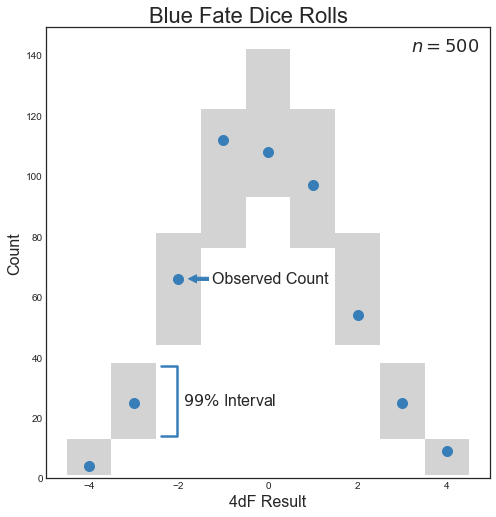

In [8]:
# Set the canvas size
fig = plt.figure(figsize=(WIDTH, HEIGHT))

ax = plt.gca()

ax.set_xlabel("4dF Result", size=16)
ax.set_ylabel("Count", size=16)

# Plot the observed points
sub_array = np.array(df["Roll Total"])
counts = np.histogram(sub_array, bins=BINS)[0]
plt.scatter(y=counts, x=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color=BLUE, s=100, zorder=POINTS_Z)

# We plot "confidence intervals" calculated by finding the point at which
# the cumulative probability of rolling a configuration of dice crosses a
# critical threshold. The white histogram is used to cover up the bottom of
# the grey histogram, giving an appearance of ranges.
lowers, uppers = zip(*get_interval(len(sub_array), start=START_INTERVAL, end=END_INTERVAL))
plt.hist(
    FAKE_COUNTS,
    bins=BINS,
    color="white",
    weights=lowers,
    linewidth=2.5,
    zorder=WHITE_HIST_Z,
)
plt.hist(
    FAKE_COUNTS,
    bins=BINS,
    color="lightgrey",
    weights=uppers,
    linewidth=2.5,
    zorder=GREY_HIST_Z,
)

# Annotate the plot
count_arrow = {
    "arrowstyle": "simple",
    "connectionstyle": "arc3",
    "color": BLUE,
    "shrinkB": 10,
}
ax.annotate(
    "Observed Count",
    (-2, counts[2]),
    xytext=(counts[2]-32, -5),
    textcoords='offset points',
    arrowprops=count_arrow,
    size=16,
    zorder=ANNOTATION_Z,
)

interval_arrow = {
    "arrowstyle": "-[",
    "connectionstyle": "arc3",
    "color": BLUE,
    "shrinkB": 10,
    "linewidth": 2.5,
}
ax.text(-1.9, (15+37)/2, "$99\%$ Interval", size=16, verticalalignment='center', horizontalalignment='left', zorder=ANNOTATION_Z)
ax.annotate(
    '', 
    xy=(-2.5, 37), 
    xycoords='data',
    xytext=(-2.5, 14), 
    textcoords='data',
    arrowprops=dict(
        arrowstyle="-",
        color=BLUE,
        connectionstyle="bar",
        shrinkA=5, 
        shrinkB=5,
        linewidth=2.5,
    ),
    zorder=ANNOTATION_Z
)

# Add a label to the plot about the dice
Y_POS = ax.get_ylim()[1] - 8
plt.text(3.2, Y_POS, "$n={n}$".format(n=len(sub_array)), size=18)

# Set main title
plt.suptitle('Blue Fate Dice Rolls', y=1.02, fontsize=22)

# Make the plots move together
plt.tight_layout()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/blue_fate_dice_rolls.{ext}".format(ext=ext), bbox_inches="tight")

# $\chi^2$ Test

Check the results with a $\chi^2$ test.

In [9]:
def expected_array(arr):
    """ Compute the expected values for each bin given a series of 4dF rolls.

    Args:
        arr (list): A list of the rolls recorded, where arr[0] is the number of
            -4s seen, and arr[8] is the number of +4s seen.

    Returns:
        list: A list of expected number of rolls seen by value.

    """
    n = sum(arr)

    result = []
    for value in range(-4, 5):
        exp = fate_probability(value) * n
        result.append(exp)

    return result

In [10]:
# Calculate the Chi2 for each set of dice, compared to the expected value for fair dice    
sub_array = np.array(df["Roll Total"])
counts = np.histogram(sub_array, bins=BINS)[0]

exp_counts = expected_array(counts)
chi, p = stats.chisquare(counts, exp_counts)
print("The statistic is {} and the p-value is {}".format(chi, p), end="\n\n")

The statistic is 5.870472368421053 and the p-value is 0.6617382738263411



# Die by die Analysis

Plots of the "random walk" of each dice.

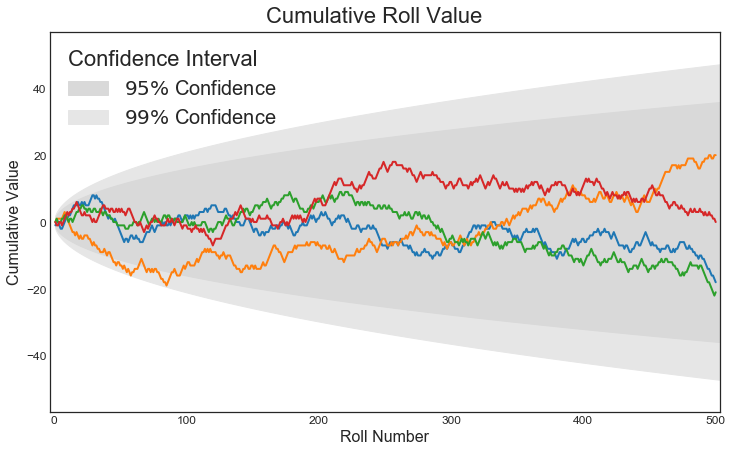

In [11]:
# Plot size
WIDTH = 12
HEIGHT = 7

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

plt.suptitle('Cumulative Roll Value', y=.93, fontsize=22)
ax.set_xlabel("Roll Number", size=16)
ax.set_ylabel("Cumulative Value", size=16)

ax.set_xlim(-3, 503)
ax.tick_params(axis='both', which='major', labelsize=12)

x = np.arange(1, 501)

for col in ["Die 1 Cumulative", "Die 2 Cumulative", "Die 3 Cumulative", "Die 4 Cumulative"]:
    y = df[col]
    
    plt.plot(x, y, linewidth=2, label="_nolegend_")

x_range = ax.get_xlim()

x_max = x_range[1] + 1

x = np.arange(1, x_max)
lines = np.sqrt((2/3) * np.arange(1, x_max))

# The two 
ax.fill_between(x, -1.96*lines, 1.96*lines, color="0.85", zorder=-1, label="$95\%$ Confidence")
ax.fill_between(x, -2.576*lines, 2.576*lines, color="0.9", zorder=-2, label="$99\%$ Confidence")

ax.set_xlim(x_range)
ax.set_ylim(ax.get_ylim()[0]-5, ax.get_ylim()[1]+5)

legend = plt.legend(loc="upper left", fontsize=20, title="Confidence Interval")
plt.setp(legend.get_title(), fontsize=22)
legend._legend_box.align = "left"
    
# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/blue_fate_dice_cumulative_rolls.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

And another random walk, but this time for the total `4dF`.

In [12]:
# Add cumulative sum columns
df_old["Cumulative"] = df_old["Result"].cumsum()

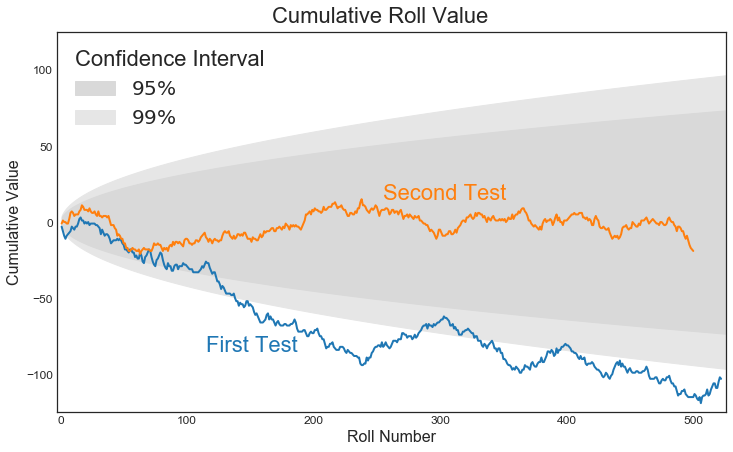

In [13]:
# Plot size
WIDTH = 12
HEIGHT = 7

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

plt.suptitle('Cumulative Roll Value', y=.93, fontsize=22)
ax.set_xlabel("Roll Number", size=16)
ax.set_ylabel("Cumulative Value", size=16)

ax.set_xlim(-3, 526)
ax.tick_params(axis='both', which='major', labelsize=12)

x = np.arange(1, 523)
y = df_old["Cumulative"]  
p0 = plt.plot(x, y, linewidth=2, label="_nolegend_")

y2 = df["Roll Total Cumulative"]  
p1 = plt.plot(x[:len(y2)], y2, linewidth=2, label="_nolegend_")

x_range = ax.get_xlim()

x_max = x_range[1] + 1

x = np.arange(1, x_max)
lines = np.sqrt((8/3) * np.arange(1, x_max))

# The two 
ax.fill_between(x, -1.96*lines, 1.96*lines, color="0.85", zorder=-1, label="$95\%$")
ax.fill_between(x, -2.576*lines, 2.576*lines, color="0.9", zorder=-2, label="$99\%$")

ax.set_xlim(x_range)
ax.set_ylim((-125, 125))

legend = plt.legend(loc="upper left", fontsize=20, title="Confidence Interval")
plt.setp(legend.get_title(), fontsize=22)
legend._legend_box.align = "left"

plt.text(115, -85, "First Test", color=p0[0].get_color(), fontsize=22)
plt.text(255, 15, "Second Test", color=p1[0].get_color(), fontsize=22)
    
# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/blue_fate_dice_cumulative_rolls_old.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)